<a href="https://colab.research.google.com/github/NazihaCode/deep-learning/blob/master/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Keras implementation of EfficientNetB0**

EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

EfficientNetB0 takes input images of shape (224, 224, 3), and the input data should range [0, 255].
Normalization is included as part of the model.
The Keras implementation by default loads pre-trained weights obtained via training with AutoAugment.

In [2]:
from tensorflow.keras.applications import EfficientNetB0
#remove the top layers
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [3]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [4]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


# **Loading data**

Stanford Dogs dataset is provided in TFDS as stanford_dogs. It features 20,580 images that belong to 120 classes of dog breeds (12,000 for training and 8,580 for testing).

In [5]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6STV8W/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6STV8W/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
#The Stanford Dogs dataset includes only images at least 200x200 pixels in size
#resize the images to the input size needed for EfficientNet
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Visualizing the **data**

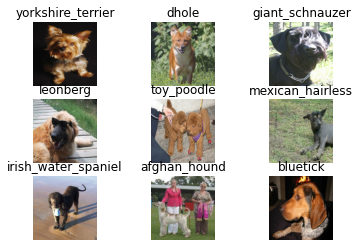

In [7]:
#The following code shows the first 9 images with their labels
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

# **Data augmentation**

In [8]:
# the preprocessing layers APIs for image augmentation
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

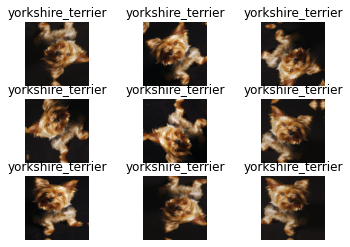

In [9]:
#plot 9 examples of augmentation result of a given figure
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

# **Prepare inputs**

In [10]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


# **Training a model from scratch**


In [11]:
# build an EfficientNetB0 with 120 output classes
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/40


187/187 - 312s - loss: 4.9712 - accuracy: 0.0119 - val_loss: 4.9474 - val_accuracy: 0.0058 - 312s/epoch - 2s/step
Epoch 2/40
187/187 - 256s - loss: 4.5983 - accuracy: 0.0257 - val_loss: 5.5054 - val_accuracy: 0.0110 - 256s/epoch - 1s/step
Epoch 3/40
187/187 - 257s - loss: 4.4215 - accuracy: 0.0338 - val_loss: 4.5710 - val_accuracy: 0.0268 - 257s/epoch - 1s/step
Epoch 4/40
187/187 - 255s - loss: 4.2997 - accuracy: 0.0418 - val_loss: 4.7310 - val_accuracy: 0.0261 - 255s/epoch - 1s/step
Epoch 5/40
187/187 - 254s - loss: 4.1832 - accuracy: 0.0561 - val_loss: 4.6281 - val_accuracy: 0.0317 - 254s/epoch - 1s/step
Epoch 6/40
187/187 - 260s - loss: 4.0772 - accuracy: 0.0669 - val_loss: 4.3689 - val_accuracy: 0.0441 - 260s/epoch - 1s/step
Epoch 7/40
187/187 - 254s - loss: 3.9769 - accuracy: 0.0786 - val_loss: 4.5303 - val_accuracy: 0.0375 - 254s/epoch - 1s/step
Epoch 8/40
187/187 - 255s - loss: 3.8595 - accuracy: 0.0988 - val_loss: 4.8463 - val_accuracy: 0.0304 - 255s/epoch - 1s/step
Epoch 9/40


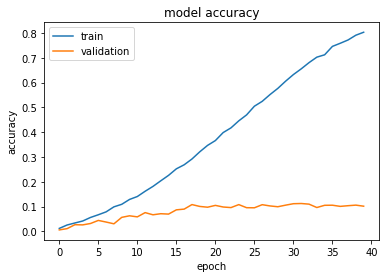

In [12]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

# **Transfer learning from pre-trained weights**

In [13]:
# initialize the model with pre-trained ImageNet weights, and  fine-tune it on our own dataset
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

The first step to transfer learning is to freeze all layers and train only the top layers.

Epoch 1/25


187/187 - 198s - loss: 2.5448 - accuracy: 0.5506 - val_loss: 0.8279 - val_accuracy: 0.7625 - 198s/epoch - 1s/step
Epoch 2/25
187/187 - 184s - loss: 1.2175 - accuracy: 0.7025 - val_loss: 0.7265 - val_accuracy: 0.7910 - 184s/epoch - 982ms/step
Epoch 3/25
187/187 - 183s - loss: 0.8400 - accuracy: 0.7591 - val_loss: 0.6897 - val_accuracy: 0.8041 - 183s/epoch - 976ms/step
Epoch 4/25
187/187 - 184s - loss: 0.7401 - accuracy: 0.7767 - val_loss: 0.6628 - val_accuracy: 0.8167 - 184s/epoch - 984ms/step
Epoch 5/25
187/187 - 183s - loss: 0.6948 - accuracy: 0.7870 - val_loss: 0.7008 - val_accuracy: 0.8109 - 183s/epoch - 977ms/step
Epoch 6/25
187/187 - 182s - loss: 0.6692 - accuracy: 0.7979 - val_loss: 0.7111 - val_accuracy: 0.8090 - 182s/epoch - 973ms/step
Epoch 7/25
187/187 - 183s - loss: 0.6779 - accuracy: 0.7940 - val_loss: 0.7542 - val_accuracy: 0.8041 - 183s/epoch - 977ms/step
Epoch 8/25
187/187 - 182s - loss: 0.6429 - accuracy: 0.8006 - val_loss: 0.8259 - val_accuracy: 0.7940 - 182s/epoch - 9

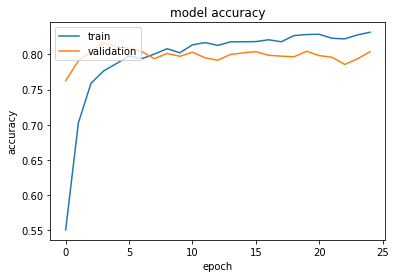

In [14]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate.

Epoch 1/10


187/187 - 217s - loss: 2.5649 - accuracy: 0.4987 - val_loss: 0.8656 - val_accuracy: 0.8139 - 217s/epoch - 1s/step
Epoch 2/10
187/187 - 186s - loss: 1.9044 - accuracy: 0.5789 - val_loss: 0.8900 - val_accuracy: 0.8126 - 186s/epoch - 997ms/step
Epoch 3/10
187/187 - 186s - loss: 1.5950 - accuracy: 0.6212 - val_loss: 0.8845 - val_accuracy: 0.8054 - 186s/epoch - 995ms/step
Epoch 4/10
187/187 - 199s - loss: 1.3949 - accuracy: 0.6495 - val_loss: 0.8937 - val_accuracy: 0.8036 - 199s/epoch - 1s/step
Epoch 5/10
187/187 - 192s - loss: 1.2240 - accuracy: 0.6832 - val_loss: 0.9015 - val_accuracy: 0.8000 - 192s/epoch - 1s/step
Epoch 6/10
187/187 - 192s - loss: 1.1227 - accuracy: 0.7002 - val_loss: 0.8897 - val_accuracy: 0.8011 - 192s/epoch - 1s/step
Epoch 7/10
187/187 - 186s - loss: 0.9986 - accuracy: 0.7234 - val_loss: 0.8918 - val_accuracy: 0.7984 - 186s/epoch - 997ms/step
Epoch 8/10
187/187 - 191s - loss: 0.9197 - accuracy: 0.7369 - val_loss: 0.8932 - val_accuracy: 0.7945 - 191s/epoch - 1s/step
Ep

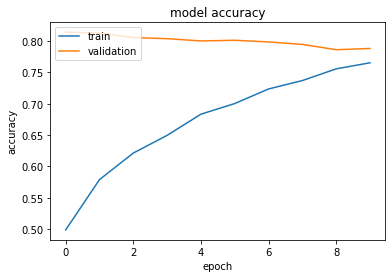

In [15]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)